# Setup

In [ ]:
# Standard library imports
import json
import os
import random

# Related third-party imports
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from google import genai

This set of import statements prepares a Python program to perform several tasks related to data analysis, visualization, and interaction with a large language model.

First, the `json` module allows the code to work with JSON (JavaScript Object Notation) formatted data – commonly used for data exchange. The `os` module provides functions for interacting with the operating system, such as reading environment variables or managing files.  The `random` module enables the generation of random numbers, which might be useful for tasks like sampling or initialization.

Next, several third-party libraries are imported. `matplotlib.pyplot` is a plotting library used to create visualizations like graphs and charts. `numpy` provides support for numerical operations, especially working with arrays and matrices.  The `dotenv` module loads environment variables from a `.env` file, keeping sensitive information (like API keys) separate from the code itself. 

Then, time series analysis tools are brought in via `statsmodels`. Specifically, `ExponentialSmoothing`, `Holt`, and `SimpleExpSmoothing` classes will be used for forecasting and smoothing time-dependent data.

Finally, `google.genai` is imported to interface with Google’s Gemini large language model, allowing the program to generate text or perform other natural language processing tasks using that AI service.

In [ ]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42
    SES_ALPHA = 0.3


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

# fix randomness - insofar as possible ;-) 
np.random.seed(CFG.SEED)
random.seed(CFG.SEED)

This code segment establishes general settings and configurations for the program, along with some initial styling choices for visualizations.

A class named `CFG` is defined to hold constant values used throughout the application. It contains three attributes: `img_dim1` and `img_dim2`, which likely represent the dimensions (width and height) of images or plots in pixels; `SEED`, an integer value used to initialize random number generators for reproducibility; and `SES_ALPHA`, a floating-point number that appears to be a smoothing factor, potentially used within exponential smoothing algorithms.

Following this, the code customizes the appearance of plots created using `matplotlib`. It sets the default plotting style to "seaborn-v0_8" and configures the default figure size based on the dimensions defined in the `CFG` class (`img_dim1` and `img_dim2`).

To enhance reproducibility, the code then seeds the random number generators used by both `numpy` and the standard `random` module with the value stored in `CFG.SEED`. This ensures that if the program is run multiple times, it will generate the same sequence of random numbers, leading to consistent results where randomness is involved.

# Utils

In [ ]:
def generate_synthetic_data() -> np.ndarray:

    time = np.arange(400, dtype=np.float32)
    series = np.zeros(400)

    # Period 1: Before the structural break (t < 200)
    series[:200] = 0.05 * time[:200] + \
                   5 * np.sin(time[:200] * 2 * np.pi / 12) + \
                   2 * np.sin(time[:200] * 2 * np.pi / 50) + 10

    # Period 2: After the structural break (t >= 200)
    series[200:] = 0.8 * (time[200:] - 200) + series[199] + \
                   5 * np.sin(time[200:] * 2 * np.pi / 12) + \
                   4 * np.sin(time[200:] * 2 * np.pi / 50)

    # Add some noise
    series += np.random.normal(0, 0.8, 400)
    return series

In [42]:
def evaluate_forecast(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """Calculates MAE and MSE for a forecast."""
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    return {'mae': mae, 'mse': mse}

In [43]:
# agent toolkit

def simple_exp_smoothing_tool(history_data: np.ndarray) -> np.ndarray:
    """
    Simple Exponential Smoothing (SES) - best for stationary data without trend.
    Forecasts are flat (constant) extending from the last smoothed value.
    """
    print("ACTION: Executing simple_exp_smoothing_tool (SES).")
    
    model = SimpleExpSmoothing(history_data, initialization_method="estimated")
    fit = model.fit(smoothing_level=CFG.SES_ALPHA, optimized=False)
    forecast = fit.forecast(forecast_horizon)
    return forecast


In [44]:
def holt_tool(history_data: np.ndarray, start_idx: int = 0) -> np.ndarray:
    """
    Double Exponential Smoothing (Holt's method) - best for data with a trend.
    Can fit on a subset of history starting from start_idx.
    """
    print(f"ACTION: Executing holt_tool (Double Exponential Smoothing) on data from index {start_idx}.")
    
    fit_data = history_data[start_idx:]
    
    model = Holt(fit_data, initialization_method="estimated")
    fit = model.fit(optimized=True)  # Let statsmodels optimize alpha and beta
    forecast = fit.forecast(forecast_horizon)
    return forecast

In [45]:
def holt_winters_tool(history_data: np.ndarray, start_idx: int = 0, seasonal_periods: int = 12) -> np.ndarray:
    """
    Triple Exponential Smoothing (Holt-Winters) - best for data with trend and seasonality.
    Can fit on a subset of history starting from start_idx.
    Parameters:
        start_idx: int - the starting index to use for fitting.
        seasonal_periods: int - the number of periods in a seasonal cycle (default=12).
    """
    print(f"ACTION: Executing holt_winters_tool (Triple Exponential Smoothing) on data from index {start_idx} with seasonal_periods {seasonal_periods}.")
    
    fit_data = history_data[start_idx:]
    
    # We use 'add' for trend and 'add' for seasonal based on the synthetic data generation
    model = ExponentialSmoothing(
        fit_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods,
        initialization_method="estimated"
    )
    fit = model.fit(optimized=True)
    forecast = fit.forecast(forecast_horizon)
    return forecast

# Prep work

In [46]:
# Generate and split the data
full_series = generate_synthetic_data()
history = full_series[:300]
future = full_series[300:]
forecast_horizon = len(future)

In [47]:
# Gemini connection
load_dotenv()
gemini_client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))


In [48]:

SYSTEM_PROMPT = """
You are an expert time series forecasting agent. You have access to the following tools:

1. simple_exp_smoothing_tool: Simple Exponential Smoothing (SES) - best for stationary data without trend.
   Produces flat forecasts. Good for stable, mean-reverting series.
   Parameters: none

2. hw_tool: Triple Exponential Smoothing (Holt-Winters method) - best for data with a trend and seasonality.
   Can capture and extrapolate linear trends. Can fit on a subset of history.
   Parameters: start_idx (int, optional, default=0) - the starting index to use for fitting.

Your task is to analyze the situation and decide which tool to use.
You must respond with ONLY a valid JSON object (no markdown, no explanation) in this exact format:
{
    "thought": "Your reasoning about the situation",
    "tool_name": "simple_exp_smoothing_tool" or "hw_tool",
    "parameters": {} or {"start_idx": <integer>}
}
"""

In [49]:
# toolkit for the agent

toolkit = {
    "simple_exp_smoothing_tool": simple_exp_smoothing_tool,
    "hw_tool": holt_winters_tool
}


In [50]:
def gemini_agent(prompt: str) -> dict:
    """
    Uses Gemini to reason about the forecasting task and return a structured plan.
    """
    print("--- Agent is PLANNING ---")
    print(f"PROMPT: \n{prompt}\n")
    
    full_prompt = f"{SYSTEM_PROMPT}\n\nUser request:\n{prompt}"
    
    response = gemini_client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=full_prompt
    )
    
    response_text = response.text.strip()
    # Clean up potential markdown formatting
    if response_text.startswith("```json"):
        response_text = response_text[7:]
    if response_text.startswith("```"):
        response_text = response_text[3:]
    if response_text.endswith("```"):
        response_text = response_text[:-3]
    response_text = response_text.strip()
    
    plan = json.loads(response_text)
    
    print(f"AGENT's PLAN: \n{json.dumps(plan, indent=2)}\n")
    return plan

In [51]:

def run_atsf_workflow(history_data: np.ndarray, ground_truth: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Executes the full, two-cycle Agentic Time Series Forecasting process.
    """
    print("=========================================")
    print("  STARTING AGENTIC FORECASTING (ATSF)  ")
    print("=========================================\n")
    
    # === CYCLE 1: Initial Forecast ===
    print("--------- CYCLE 1 ---------")
    
    # 1. PERCEPTION: Agent receives the initial task.
    initial_prompt = "Forecast the next 100 time steps for the provided series. Choose the best tool to start with."
    
    # 2. PLANNING: Agent formulates a plan.
    plan_1 = gemini_agent(initial_prompt)
    
    # 3. ACTION: Execute the plan.
    tool_to_use = toolkit[plan_1['tool_name']]
    initial_forecast = tool_to_use(history_data, **plan_1['parameters'])
    
    # Evaluate the first attempt
    metrics_1 = evaluate_forecast(ground_truth, initial_forecast)
    print(f"\nInitial Forecast Performance (Cycle 1): MAE={metrics_1['mae']:.2f}, MSE={metrics_1['mse']:.2f}\n")

    # === CYCLE 2: Reflection and Refinement ===
    print("--------- CYCLE 2 ---------")
    
    # 4. REFLECTION: Agent perceives the poor outcome and is prompted to reflect.
    reflection_prompt = f"""
    Reflect on the poor performance of the initial forecast (MAE: {metrics_1['mae']:.2f}). 
    The historical data spans 300 time steps, and there appears to be a structural break around t=200 
    where the trend becomes significantly steeper.
    Hypothesize a reason for the failure and formulate a new, improved plan.
    Consider using data only from after the structural break (index 200 onwards) for a simpler model.
    """
    
    # 5. RE-PLANNING: Agent re-evaluates and creates a new plan.
    plan_2 = gemini_agent(reflection_prompt)
    
    # 6. ACTION (Revised): Execute the new plan.
    tool_to_use = toolkit[plan_2['tool_name']]
    final_forecast = tool_to_use(history_data, **plan_2['parameters'])
    
    # Evaluate the final attempt
    metrics_2 = evaluate_forecast(ground_truth, final_forecast)
    print(f"\nFinal Forecast Performance (Cycle 2): MAE={metrics_2['mae']:.2f}, MSE={metrics_2['mse']:.2f}\n")
    
    print("=========================================")
    print("         ATSF WORKFLOW COMPLETE        ")
    print("=========================================")
    
    return initial_forecast, final_forecast



# Run Forrest run

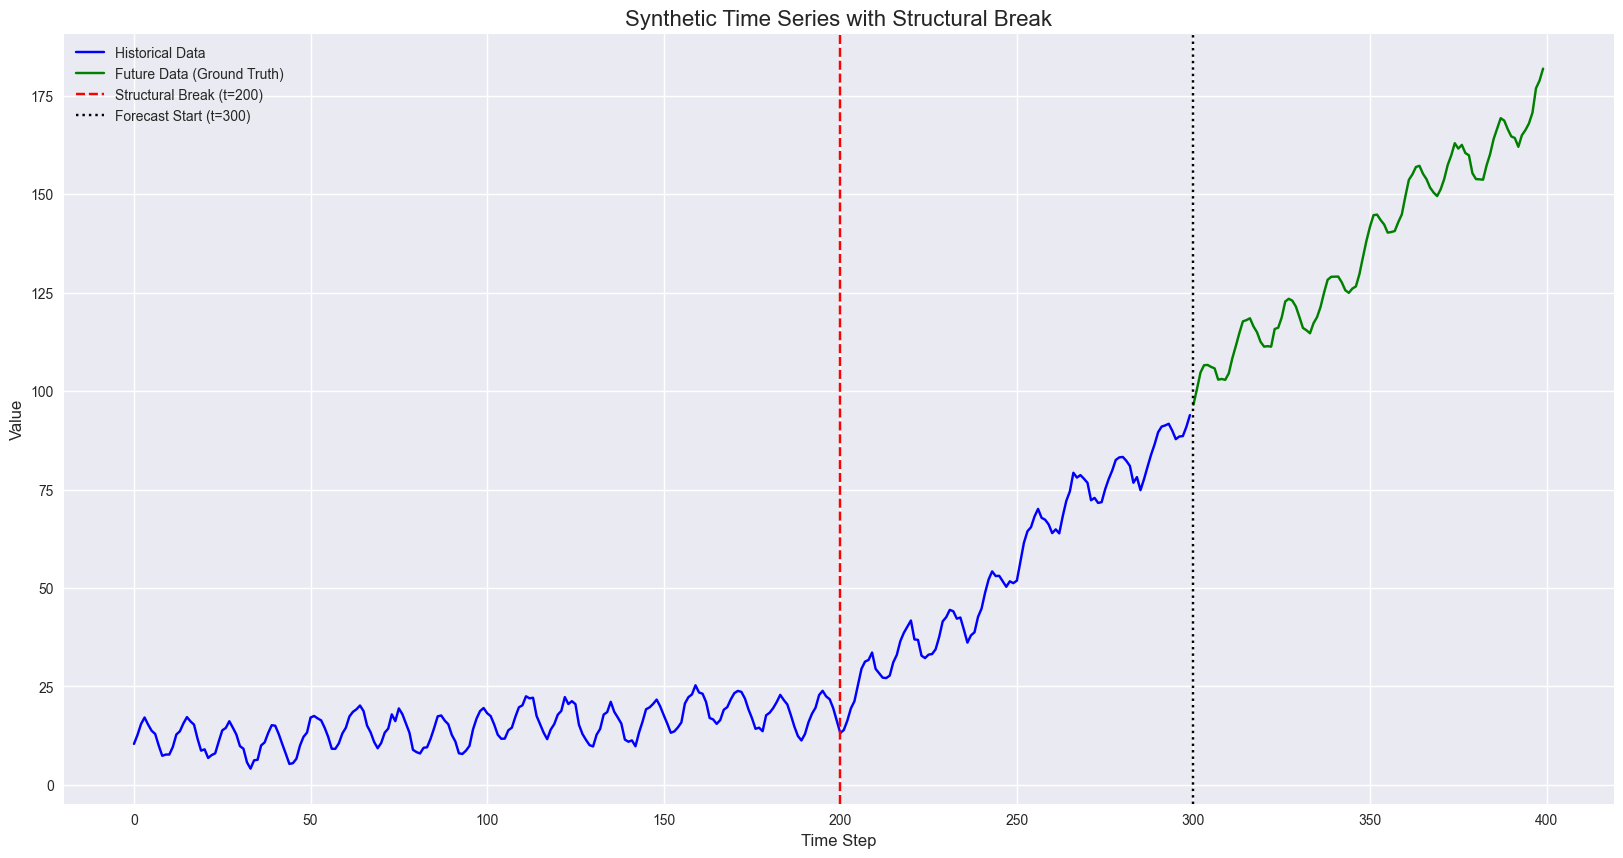

In [52]:
    plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.plot(np.arange(300), history, label='Historical Data', color='blue')
    plt.plot(np.arange(300, 400), future, label='Future Data (Ground Truth)', color='green')
    plt.axvline(x=200, color='red', linestyle='--', label='Structural Break (t=200)')
    plt.axvline(x=300, color='black', linestyle=':', label='Forecast Start (t=300)')
    plt.title('Synthetic Time Series with Structural Break', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()

In [53]:
    print(f"Total series length: {len(full_series)}")
    print(f"Historical data length: {len(history)}")
    print(f"Future data length (forecast horizon): {len(future)}")

Total series length: 400
Historical data length: 300
Future data length (forecast horizon): 100


In [54]:
    # Generate Baseline Forecast using Simple Exponential Smoothing
    print("\nGenerating baseline forecast with Simple Exponential Smoothing...")
    baseline_pred = simple_exp_smoothing_tool(history)
    baseline_metrics = evaluate_forecast(future, baseline_pred)
    print(f"\nBaseline Model-Centric Performance:")
    print(f"  MAE: {baseline_metrics['mae']:.4f}")
    print(f"  MSE: {baseline_metrics['mse']:.4f}")


Generating baseline forecast with Simple Exponential Smoothing...
ACTION: Executing simple_exp_smoothing_tool (SES).

Baseline Model-Centric Performance:
  MAE: 46.2871
  MSE: 2642.9825


In [55]:
    # Run the Agentic Workflow
    initial_agent_forecast, final_agent_forecast = run_atsf_workflow(history, future)


  STARTING AGENTIC FORECASTING (ATSF)  

--------- CYCLE 1 ---------
--- Agent is PLANNING ---
PROMPT: 
Forecast the next 100 time steps for the provided series. Choose the best tool to start with.

AGENT's PLAN: 
{
  "thought": "I need to choose a tool to forecast the next 100 time steps. Without any further information about the time series, I will start with the assumption that there is no trend or seasonality and will choose the simplest model. If the results are poor, I will then analyze the results to determine the nature of the time series, and then choose a more sophisticated model.",
  "tool_name": "simple_exp_smoothing_tool",
  "parameters": {}
}

ACTION: Executing simple_exp_smoothing_tool (SES).

Initial Forecast Performance (Cycle 1): MAE=46.29, MSE=2642.98

--------- CYCLE 2 ---------
--- Agent is PLANNING ---
PROMPT: 

    Reflect on the poor performance of the initial forecast (MAE: 46.29). 
    The historical data spans 300 time steps, and there appears to be a structu

In [56]:

    # Calculate final metrics
    agent_final_metrics = evaluate_forecast(future, final_agent_forecast)


In [57]:
    # Display Results
    print("\n| Approach                    |   MAE   |   MSE   |")
    print("|-----------------------------|---------|---------")
    print(f"| Model-Centric (Baseline)    | {baseline_metrics['mae']:>7.2f} | {baseline_metrics['mse']:>7.2f} |")
    print(f"| Agentic (ATSF Final)        | {agent_final_metrics['mae']:>7.2f} | {agent_final_metrics['mse']:>7.2f} |")
    
    improvement_mae = (baseline_metrics['mae'] - agent_final_metrics['mae']) / baseline_metrics['mae'] * 100
    improvement_mse = (baseline_metrics['mse'] - agent_final_metrics['mse']) / baseline_metrics['mse'] * 100
    
    print("\n--- Performance Improvement ---")
    print(f"The agentic approach improved MAE by {improvement_mae:.2f}% over the baseline.")
    print(f"The agentic approach improved MSE by {improvement_mse:.2f}% over the baseline.")
    
  


| Approach                    |   MAE   |   MSE   |
|-----------------------------|---------|---------
| Model-Centric (Baseline)    |   46.29 | 2642.98 |
| Agentic (ATSF Final)        |   31.38 | 1358.21 |

--- Performance Improvement ---
The agentic approach improved MAE by 32.20% over the baseline.
The agentic approach improved MSE by 48.61% over the baseline.


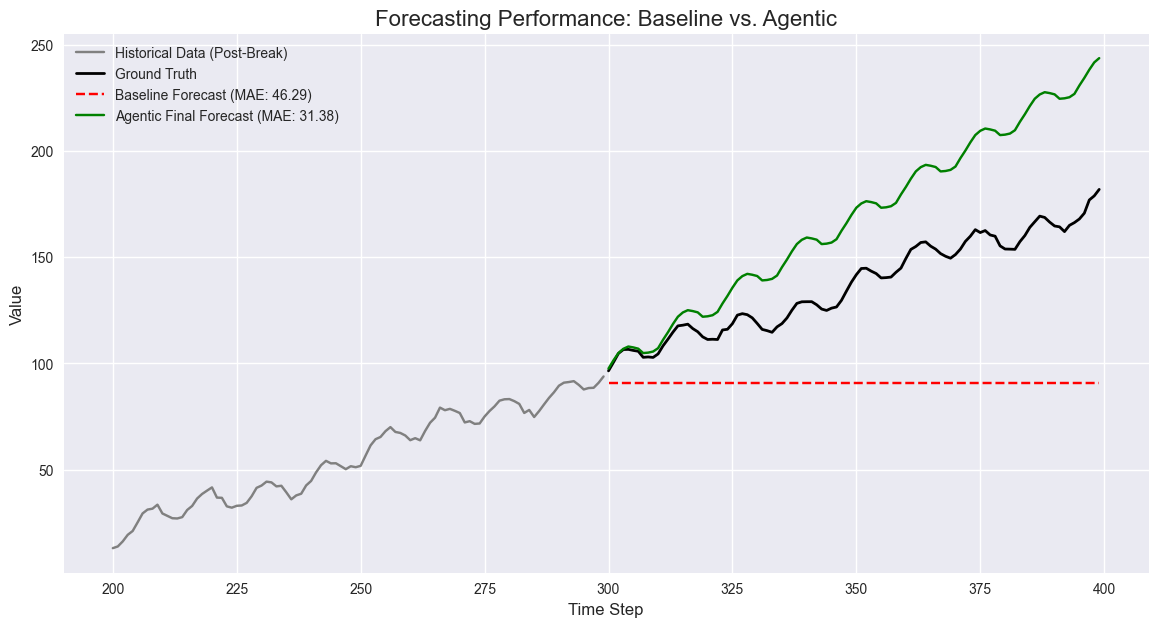

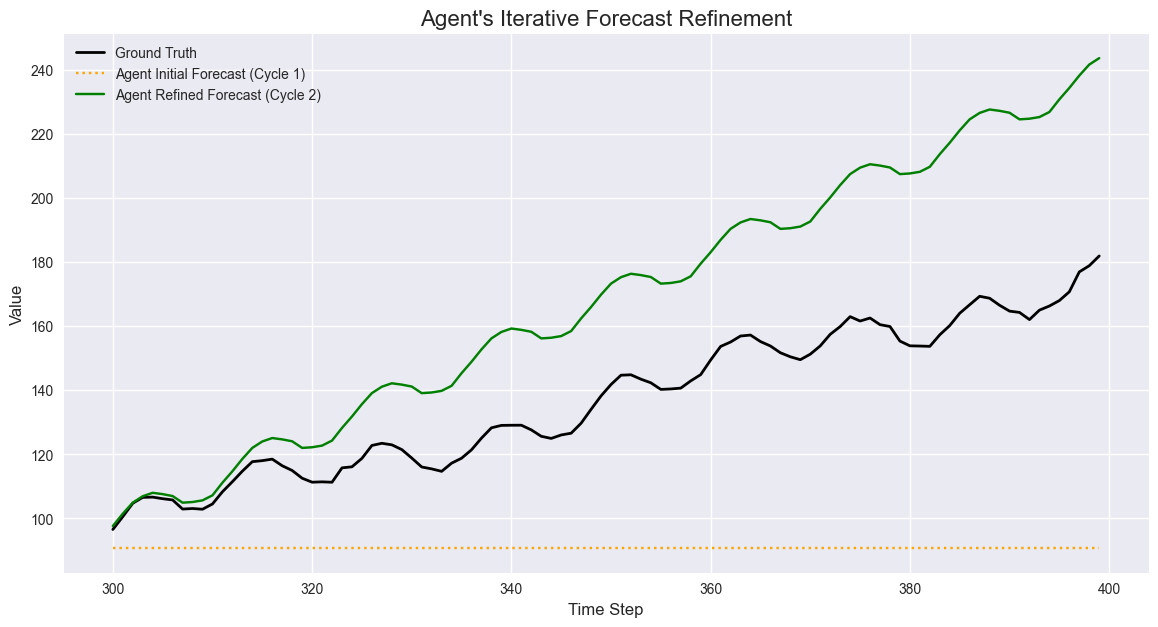

In [58]:
    # Visualizations
    time_future = np.arange(300, 400)
    
    # Plot 1: Baseline vs. Agentic Final Forecast
    plt.figure(figsize=(14, 7))
    plt.plot(np.arange(200, 300), history[200:], label='Historical Data (Post-Break)', color='gray')
    plt.plot(time_future, future, label='Ground Truth', color='black', linewidth=2, linestyle='-')
    plt.plot(time_future, baseline_pred, label=f'Baseline Forecast (MAE: {baseline_metrics["mae"]:.2f})', color='red', linestyle='--')
    plt.plot(time_future, final_agent_forecast, label=f'Agentic Final Forecast (MAE: {agent_final_metrics["mae"]:.2f})', color='green', linestyle='-')
    plt.title('Forecasting Performance: Baseline vs. Agentic', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()
    
    # Plot 2: Agent's Iterative Refinement
    plt.figure(figsize=(14, 7))
    plt.plot(time_future, future, label='Ground Truth', color='black', linewidth=2, linestyle='-')
    plt.plot(time_future, initial_agent_forecast, label='Agent Initial Forecast (Cycle 1)', color='orange', linestyle=':')
    plt.plot(time_future, final_agent_forecast, label='Agent Refined Forecast (Cycle 2)', color='green', linestyle='-')
    plt.title("Agent's Iterative Forecast Refinement", fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.show()